In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('TCS.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [ ]:
period= 5

In [ ]:
# roc
data['roc'] = ((data['Close'] - data['Close'].shift(period)) / data['Close'].shift(period)) * 100


In [ ]:
# rsi
data['change_wrt_prevday'] = data['Close']- data['Close'].shift(1)

data['gain']=np.where(data['change_wrt_prevday'] >= 0,data['change_wrt_prevday'], 0)
data['loss']=np.where(data['change_wrt_prevday'] < 0,-data['change_wrt_prevday'], 0)

data['avg_gain'] = data['gain'].rolling(window=period).mean()
data['avg_loss'] = data['loss'].rolling(window=period).mean()

data['rsi'] = 100 - (100 / (1 + (data['avg_gain'] / data['avg_loss'])))

In [ ]:
# Bollinger bands

data['SMA'] = data['Close'].rolling(window=period).mean()
data['SD'] = data['Close'].rolling(window=period).std()

data['UB'] = data['SMA'] + 2* data['SD']
data['LB'] = data['SMA'] - 2* data['SD']
data['bb'] = data['UB']-data['LB']
# data['Signal'] = 0
# data.loc[data['Close'] <= data['LB'], 'Signal'] = 1
# data.loc[data['Close'] >= data['UB'], 'Signal'] = -1

In [ ]:
data.head(15)

,Date,Open,High,Low,Volume,Close,Adj Close,roc,change_wrt_prevday,gain,loss,avg_gain,avg_loss,rsi,SMA,SD,UB,LB,bb
0,2002-08-12,38.724998,40.000000,38.724998,212976,39.700001,27.853680,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-08-13,39.750000,40.387501,38.875000,153576,39.162498,27.476551,NaN,-0.537502,0.000000,0.537502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-08-14,39.250000,39.250000,35.724998,822776,36.462502,25.582241,NaN,-2.699997,0.000000,2.699997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-08-15,36.462502,36.462502,36.462502,0,36.462502,25.582241,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-08-16,36.275002,38.000000,35.750000,811856,36.375000,25.520840,NaN,-0.087502,0.000000,0.087502,0.000000,0.665000,0.000000,37.632500,1.653372,40.939244,34.325757,6.613487
5,2002-08-19,36.674999,36.674999,35.137501,205880,35.474998,24.889397,-10.642323,-0.900002,0.000000,0.900002,0.000000,0.845000,0.000000,36.787500,1.391463,39.570427,34.004573,5.565854
6,2002-08-20,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,0.987503,0.987503,0.000000,0.197501,0.737500,21.123046,36.247501,0.433501,37.114502,35.380499,1.734003
7,2002-08-21,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,1.787498,1.787498,0.000000,0.555000,0.197501,73.754104,36.605000,1.009510,38.624020,34.585981,4.038039
8,2002-08-22,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,1.650002,1.650002,0.000000,0.885001,0.197501,81.755160,37.292500,1.771291,40.835082,33.749918,7.085164
9,2002-08-23,40.250000,43.625000,39.762501,4841672,42.299999,29.677847,16.288658,2.399998,2.399998,0.000000,1.365000,0.180000,88.349498,38.477500,2.727728,43.932956,33.022044,10.910912


In [ ]:
data = data.dropna(subset=['rsi'])

In [ ]:
data = data.fillna(0)

In [ ]:
data=data.reset_index(drop=True)

In [ ]:
data

,Date,Open,High,Low,Volume,Close,Adj Close,roc,change_wrt_prevday,gain,loss,avg_gain,avg_loss,rsi,SMA,SD,UB,LB,bb
0,2002-08-16,36.275002,38.000000,35.750000,811856,36.375000,25.520840,0.000000,-0.087502,0.000000,0.087502,0.000000,0.665000,0.000000,37.632500,1.653372,40.939244,34.325757,6.613487
1,2002-08-19,36.674999,36.674999,35.137501,205880,35.474998,24.889397,-10.642323,-0.900002,0.000000,0.900002,0.000000,0.845000,0.000000,36.787500,1.391463,39.570427,34.004573,5.565854
2,2002-08-20,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,0.987503,0.987503,0.000000,0.197501,0.737500,21.123046,36.247501,0.433501,37.114502,35.380499,1.734003
3,2002-08-21,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,1.787498,1.787498,0.000000,0.555000,0.197501,73.754104,36.605000,1.009510,38.624020,34.585981,4.038039
4,2002-08-22,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,1.650002,1.650002,0.000000,0.885001,0.197501,81.755160,37.292500,1.771291,40.835082,33.749918,7.085164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2024-07-22,4299.950195,4319.950195,4265.000000,1896386,4287.350098,4287.350098,2.471346,-15.049805,0.000000,15.049805,29.269922,8.589941,77.311219,4250.590039,70.858660,4392.307359,4108.872719,283.434639
5160,2024-07-23,4283.000000,4361.700195,4266.299805,2365208,4302.350098,4302.350098,3.193656,15.000000,15.000000,0.000000,32.269922,5.639941,85.122760,4277.220020,56.108859,4389.437738,4165.002301,224.435438
5161,2024-07-24,4287.500000,4339.100098,4268.100098,1809793,4306.250000,4306.250000,3.058546,3.899902,3.899902,0.000000,31.199902,5.639941,84.690648,4302.779980,10.167595,4323.115171,4282.444790,40.670382
5162,2024-07-25,4295.000000,4343.000000,4274.200195,2810342,4322.500000,4322.500000,0.161050,16.250000,16.250000,0.000000,7.029980,5.639941,55.485587,4304.170020,12.546610,4329.263240,4279.076799,50.186441


In [ ]:
features = ['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Close', 'roc', 'rsi', 'bb']
target = 'Close'

In [ ]:
data

,Date,Open,High,Low,Volume,Close,Adj Close,roc,change_wrt_prevday,gain,...,time_encoded_55,time_encoded_56,time_encoded_57,time_encoded_58,time_encoded_59,time_encoded_60,time_encoded_61,time_encoded_62,time_encoded_63,time_encoded_64
0,2002-08-16,36.275002,38.000000,35.750000,811856,36.375000,25.520840,0.000000,-0.087502,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2002-08-19,36.674999,36.674999,35.137501,205880,35.474998,24.889397,-10.642323,-0.900002,0.000000,...,-0.999463,0.078920,0.443395,0.558682,-0.964816,-0.474093,-0.999997,0.886270,0.951467,0.953095
2,2002-08-20,35.724998,38.724998,35.487499,3773624,36.462502,25.582241,-6.894343,0.987503,0.987503,...,-0.537358,-0.406173,0.088794,-0.967207,-0.168059,-0.925433,0.999994,0.800846,-0.807972,0.917123
3,2002-08-21,38.474998,39.200001,36.525002,3011064,38.250000,26.836346,4.902292,1.787498,1.787498,...,0.451968,-0.792884,-0.277855,0.894093,0.823199,-0.955447,-0.999991,0.694831,-0.002219,0.871525
4,2002-08-22,39.512501,41.575001,39.312500,6732480,39.900002,27.994001,9.427494,1.650002,1.650002,...,0.997852,-0.987543,-0.606802,-0.375748,0.861739,-0.550471,0.999988,0.570950,0.810580,0.816779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5159,2024-07-22,4299.950195,4319.950195,4265.000000,1896386,4287.350098,4287.350098,2.471346,-15.049805,0.000000,...,0.085096,0.998900,-0.573887,0.992240,0.070564,-0.999734,-0.933337,-0.512655,-0.212470,-0.399697
5160,2024-07-23,4283.000000,4361.700195,4266.299805,2365208,4302.350098,4302.350098,3.193656,15.000000,15.000000,...,-0.814039,0.855551,-0.831452,-0.663089,-0.874914,-0.757505,0.933039,-0.368832,-0.665990,-0.303808
5161,2024-07-24,4287.500000,4339.100098,4268.100098,1809793,4306.250000,4306.250000,3.058546,3.899902,3.899902,...,-0.914491,0.504972,-0.976200,0.003740,-0.807824,-0.170403,-0.932740,-0.215526,0.994909,-0.204731
5162,2024-07-25,4295.000000,4343.000000,4274.200195,2810342,4322.500000,4322.500000,0.161050,16.250000,16.250000,...,-0.117703,0.032080,-0.988491,0.657471,0.194189,0.494278,0.932440,-0.056677,-0.502882,-0.103505


In [ ]:
sequence_length = 100

In [ ]:
X = []
y = []

for i in range(len(data) - sequence_length):
    X.append(data[features].iloc[i:i+sequence_length].values)
    y.append(data[target].iloc[i+sequence_length])

In [ ]:
X = np.array(X)
y = np.array(y).reshape(-1, 1)

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[2])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
s = 0.9
X_train = X_scaled[:int(s*len(X))]
X_test = X_scaled[int(s*len(X)):]
y_train = y_scaled[:int(s*len(y))]
y_test = y_scaled[int(s*len(y)):]


In [ ]:
X_train.shape

(4557, 100, 75)

In [ ]:
  # model = Sequential()
# # model.add(InputLayer((100,6)))
# model.add(LSTM(128,activation='relu'))
# model.add(LSTM(128,activation='relu'))
# model.add(Dense(8,'relu'))
# model.add(Dense(1,'linear'))

model=Sequential()
model.add(LSTM(128,return_sequences=False,input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.005), loss='mean_squared_error')
# history=model.fit(X_train,y_train, batch_size = 128,epochs = 200,validation_split=0.2, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_split=0.2,
                    verbose=1, callbacks=[early_stopping])

Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.1432 - val_loss: 0.0356
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0090 - val_loss: 0.0145
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0048 - val_loss: 0.0401
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0673
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 0.1313
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.1230
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 0.1511
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0022 - val_loss: 0.1737
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.1619
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - val_loss: 0.1929
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0020 - val_loss: 0.1805
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

In [ ]:
y_test_pred_scaled = model.predict(X_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_scaled)

159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


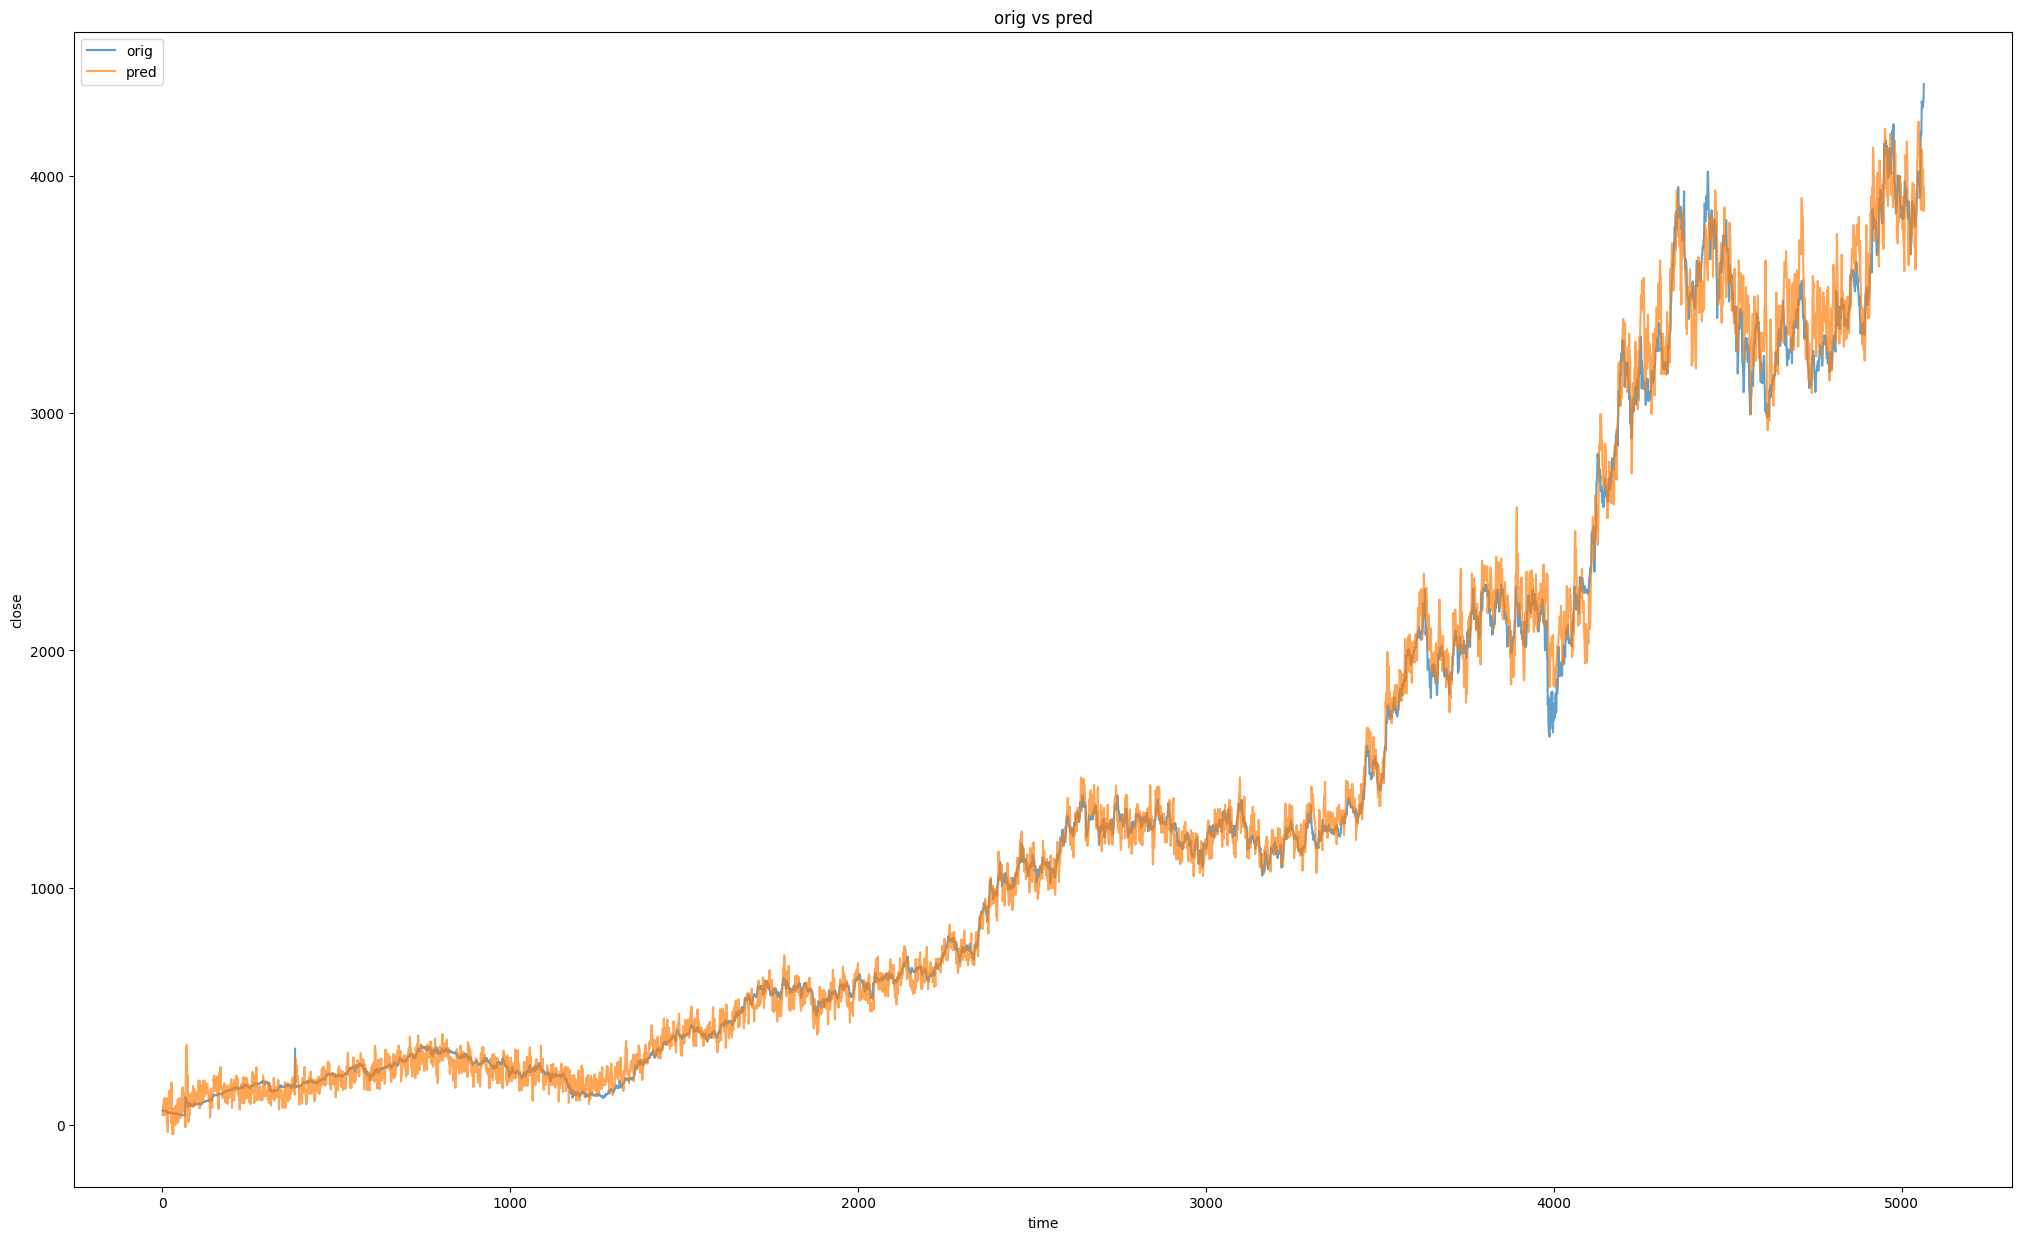

In [ ]:
plt.figure(figsize=(25, 15))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [ ]:
y_test_pred_scaled = model.predict(X_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


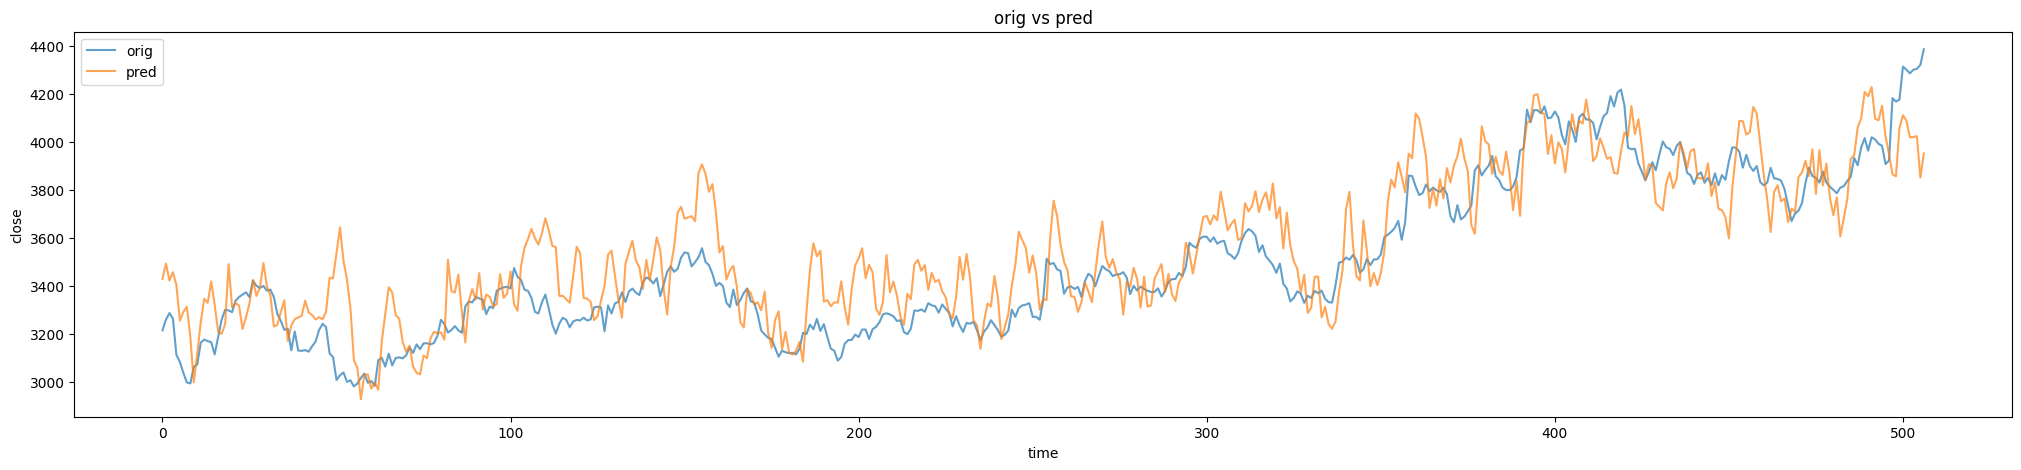

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(y_test_actual, label='orig', alpha=0.7)
plt.plot(y_test_pred, label='pred', alpha=0.7)
plt.title('orig vs pred')
plt.xlabel('time')
plt.ylabel('close')
plt.legend()
plt.show()

In [ ]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
train_accuracy = 1 - train_loss

test_loss = model.evaluate(X_test, y_test, verbose=0)
test_accuracy = 1 - test_loss

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9955795956775546
Test Accuracy: 0.980829481035471
